In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
import torch.nn as nn
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from pinns import *
from local_utils import *

from pinns import *
from intro import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

In [3]:
import pickle
with open(f"./inputs/solution_60.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

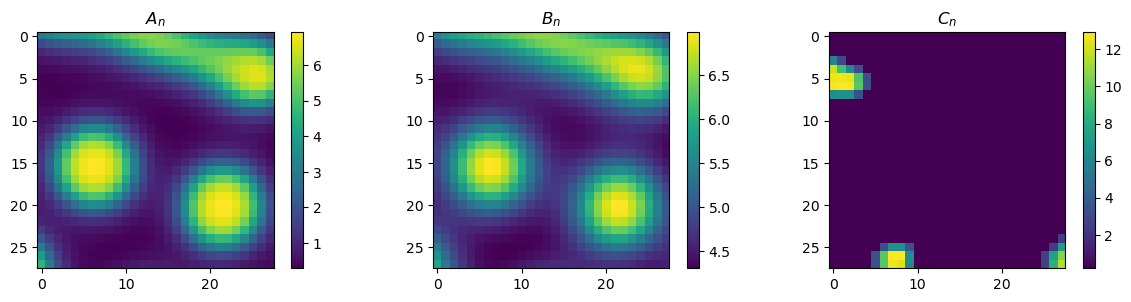

In [4]:
A_n = solution[-1, 0, :, :]
B_n = solution[-1, 1, :, :]
C_n = solution[-1, 2, :, :]

#############################################################
#    Inner boundaries
# By using these slices, we can remove the boundary effects
# or select a smaller portion of the domain
#
#   Important: slices must not be larger than slices(1,-1,1).
#              Otherwise, the boundary effects of finit difference
#              Laplacian cannot be removed
#
x_slice = slice(50,-50, 1)
y_slice = slice(50,-50, 1)

to = create_to(A_n[x_slice,y_slice])
########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


A_n = ndimage.convolve(A_n, kernel)/4
B_n = ndimage.convolve(B_n, kernel)/4
C_n = ndimage.convolve(C_n, kernel)/4
############################################################
plot_n_im([A_n[x_slice,y_slice], 
           B_n[x_slice,y_slice], 
           C_n[x_slice,y_slice]], 
          [r"$A_{n}$", r"$B_{n}$", r"$C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [5]:
A_min, A_max = np.min(A_n), np.max(A_n)
B_min, B_max = np.min(B_n), np.max(B_n)
C_min, C_max = np.min(C_n), np.max(C_n)
n = 1#params["n"]
tol = .05

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)
n_AA_bound = (1.0, 6.0)
n_AB_bound = (1.0, 6.0)
n_AC_bound = (1.0, 6.0)
n_BA_bound = (1.0, 6.0)
n_BC_bound = (1.0, 6.0)
n_CB_bound = (1.0, 6.0)
n_CC_bound = (1.0, 6.0)

Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC":K_CC_bound}

ns_bounds = {"n_AA":n_AA_bound, 
             "n_AB":n_AB_bound, 
             "n_AC":n_AC_bound,
             "n_BA":n_BA_bound, 
             "n_BC":n_BC_bound,
             "n_CB":n_CB_bound, 
             "n_CC":n_CC_bound}

def closest_bound(name, v):
    if not (name.startswith("K") or name.startswith("n")):
        return np.nan
    if name.startswith("K"):
        lower, upper = Ks_bounds[name]
    else:
        lower, upper = ns_bounds[name]
        
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not (name.startswith("K") or name.startswith("n")):
        return (0, None)
    if name.startswith("K"):
        return Ks_bounds[name]
    else:
        return ns_bounds[name]

Epoch: 1 
 data loss:10.491618, 
data A loss:3.276086, data B loss:5.194270, data C loss:2.021263, 
Laplacian A loss:68.652679, Laplacian B loss:21.568694
Physics loss:1.750050
Negative loss:0.134072

 b_A=0.9000, b_B=0.9000, b_C=0.9000, V_A=1.0000, V_B=1.0000, V_C=1.0000, mu_A=0.9000, mu_B=1.1000, K_AA=1.0000, K_AB=1.0000, K_AC=1.0000, K_BA=1.0000, K_BC=1.0000, K_CB=1.0000, K_CC=1.0000, n_AA=2.0000, n_AB=2.0000, n_AC=2.0000, n_BA=2.0000, n_BC=2.0000, n_CB=2.0000, n_CC=2.0000


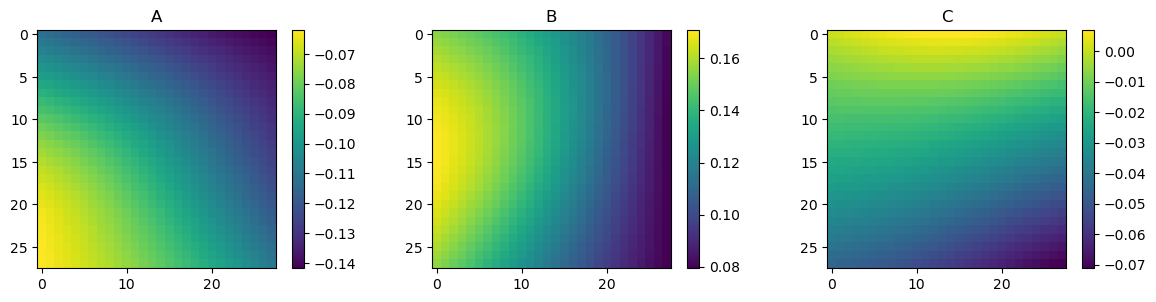

Epoch: 5000 
 data loss:0.177966, 
data A loss:0.060818, data B loss:0.026957, data C loss:0.090191, 
Laplacian A loss:0.273026, Laplacian B loss:0.287168
Physics loss:0.487177
Negative loss:0.002875

 b_A=-0.0012, b_B=12.6998, b_C=0.0400, V_A=17.0361, V_B=114.4514, V_C=25.9901, mu_A=0.5117, mu_B=5.6225, K_AA=5.4675, K_AB=5.3297, K_AC=15.8376, K_BA=6.2398, K_BC=13.7598, K_CB=19.6580, K_CC=33.5524, n_AA=3.3357, n_AB=3.3697, n_AC=6.0002, n_BA=5.1864, n_BC=5.5738, n_CB=6.0014, n_CC=1.1804


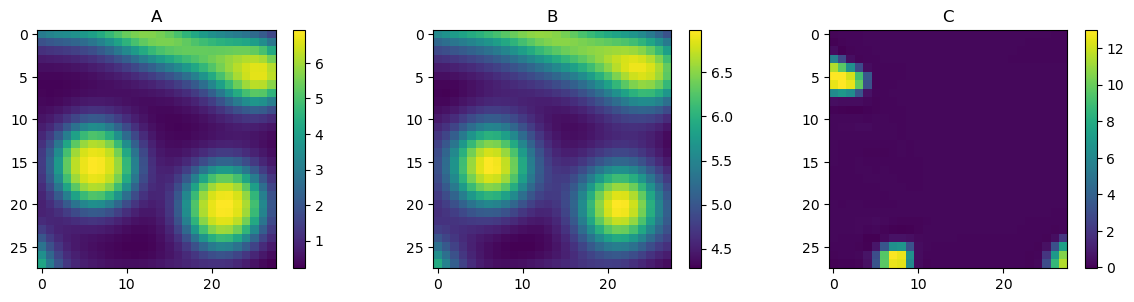

Epoch: 10000 
 data loss:0.065642, 
data A loss:0.030986, data B loss:0.013175, data C loss:0.021481, 
Laplacian A loss:0.160882, Laplacian B loss:0.116181
Physics loss:0.277814
Negative loss:0.000000

 b_A=0.0108, b_B=13.3843, b_C=0.0366, V_A=19.0008, V_B=113.5684, V_C=31.9368, mu_A=0.5267, mu_B=5.7592, K_AA=5.4124, K_AB=5.2885, K_AC=16.6564, K_BA=5.9515, K_BC=12.4105, K_CB=21.9373, K_CC=42.6458, n_AA=3.3416, n_AB=3.4053, n_AC=6.0003, n_BA=4.5640, n_BC=4.0955, n_CB=5.9439, n_CC=1.1479


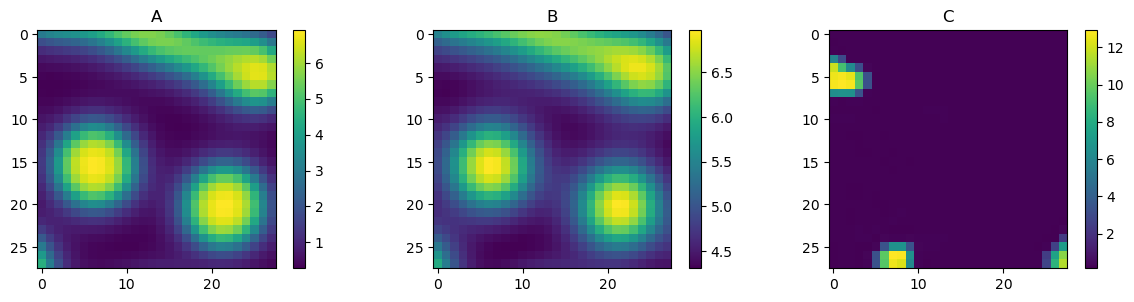

Epoch: 15000 
 data loss:0.044904, 
data A loss:0.026248, data B loss:0.010581, data C loss:0.008075, 
Laplacian A loss:0.094974, Laplacian B loss:0.079361
Physics loss:0.238156
Negative loss:0.000000

 b_A=0.0110, b_B=13.2367, b_C=0.0329, V_A=19.9146, V_B=113.0794, V_C=35.1937, mu_A=0.5290, mu_B=5.7256, K_AA=5.4026, K_AB=5.2791, K_AC=17.4896, K_BA=5.8297, K_BC=11.9460, K_CB=18.5547, K_CC=48.0107, n_AA=3.3671, n_AB=3.4216, n_AC=6.0004, n_BA=4.4657, n_BC=4.1745, n_CB=2.5961, n_CC=1.1347


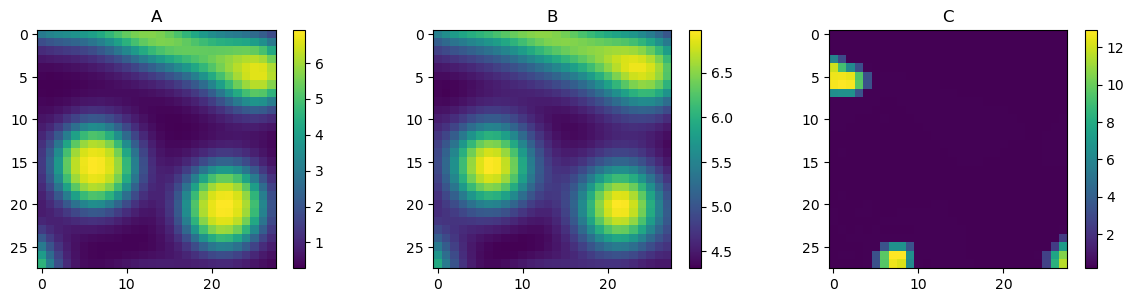

Epoch: 20000 
 data loss:0.039459, 
data A loss:0.025136, data B loss:0.009399, data C loss:0.004924, 
Laplacian A loss:0.084593, Laplacian B loss:0.065611
Physics loss:0.222545
Negative loss:0.000000

 b_A=0.0120, b_B=13.1198, b_C=0.0323, V_A=20.4261, V_B=112.8359, V_C=37.4790, mu_A=0.5297, mu_B=5.6982, K_AA=5.3966, K_AB=5.2740, K_AC=18.2286, K_BA=5.7620, K_BC=12.0259, K_CB=9.1962, K_CC=51.9845, n_AA=3.3718, n_AB=3.4276, n_AC=6.0004, n_BA=4.3802, n_BC=4.2317, n_CB=5.7147, n_CC=1.1240


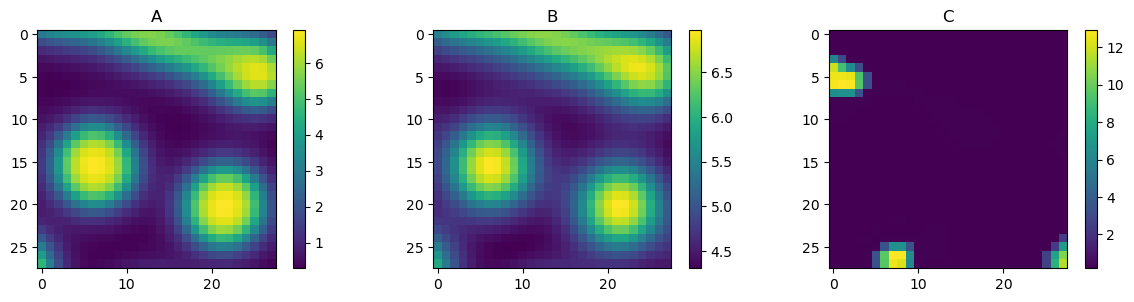

Epoch: 25000 
 data loss:0.037138, 
data A loss:0.024740, data B loss:0.008446, data C loss:0.003952, 
Laplacian A loss:0.087530, Laplacian B loss:0.057796
Physics loss:0.211242
Negative loss:0.000000

 b_A=0.0136, b_B=13.0527, b_C=0.0339, V_A=20.7456, V_B=112.6964, V_C=39.3497, mu_A=0.5321, mu_B=5.6830, K_AA=5.3900, K_AB=5.2713, K_AC=18.8141, K_BA=5.7192, K_BC=12.1889, K_CB=9.1773, K_CC=55.2176, n_AA=3.3626, n_AB=3.4304, n_AC=6.0004, n_BA=4.2865, n_BC=4.2357, n_CB=6.0095, n_CC=1.1148


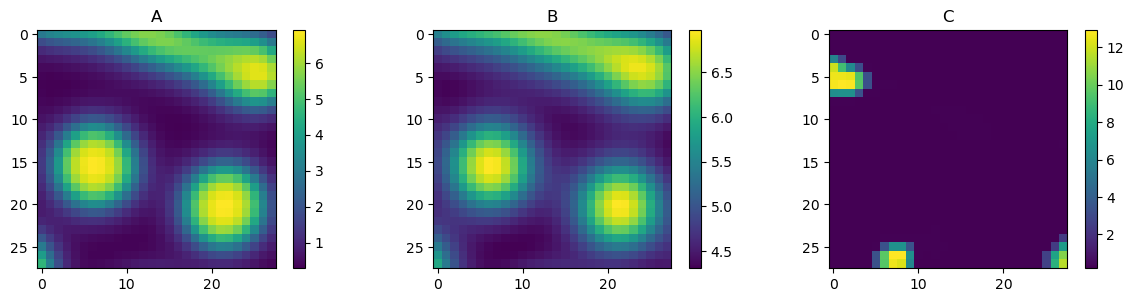

Epoch: 30000 
 data loss:0.037864, 
data A loss:0.024510, data B loss:0.007996, data C loss:0.005358, 
Laplacian A loss:0.057162, Laplacian B loss:0.052867
Physics loss:0.206356
Negative loss:0.000000

 b_A=0.0146, b_B=13.0137, b_C=0.0232, V_A=20.9788, V_B=112.6046, V_C=40.8917, mu_A=0.5302, mu_B=5.6734, K_AA=5.3859, K_AB=5.2687, K_AC=19.2864, K_BA=5.6885, K_BC=12.3656, K_CB=9.1830, K_CC=57.9390, n_AA=3.3738, n_AB=3.4328, n_AC=6.0001, n_BA=4.2765, n_BC=4.2432, n_CB=6.0150, n_CC=1.1208


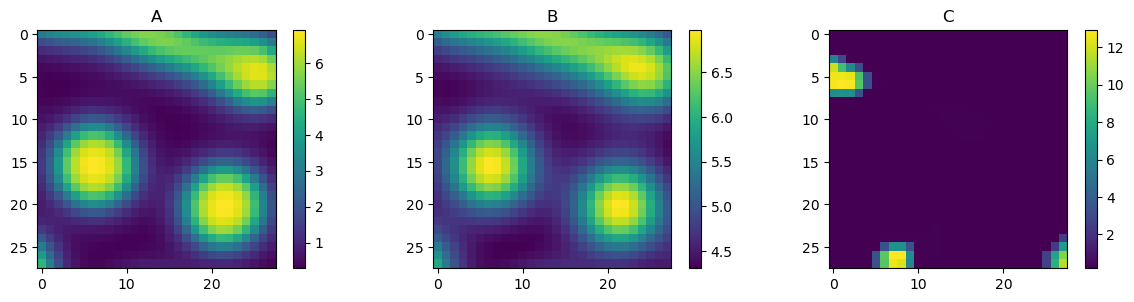

Epoch: 35000 
 data loss:0.050740, 
data A loss:0.025250, data B loss:0.013287, data C loss:0.012203, 
Laplacian A loss:0.187986, Laplacian B loss:0.094791
Physics loss:0.363127
Negative loss:0.000000

 b_A=0.0109, b_B=12.9930, b_C=0.0336, V_A=21.1351, V_B=112.5463, V_C=42.2504, mu_A=0.5210, mu_B=5.6640, K_AA=5.4034, K_AB=5.2626, K_AC=19.6757, K_BA=5.6656, K_BC=12.5779, K_CB=9.1081, K_CC=60.3098, n_AA=3.3405, n_AB=3.4283, n_AC=6.0003, n_BA=4.1847, n_BC=4.2933, n_CB=6.0066, n_CC=1.1051


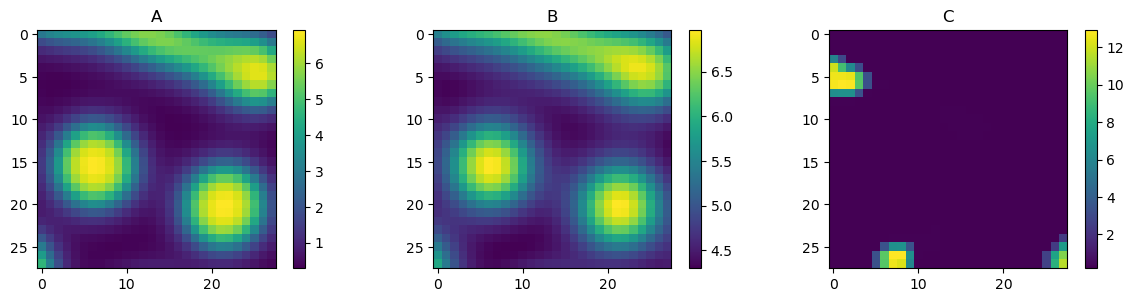

Epoch: 40000 
 data loss:0.034835, 
data A loss:0.024266, data B loss:0.007722, data C loss:0.002847, 
Laplacian A loss:0.080895, Laplacian B loss:0.048117
Physics loss:0.203836
Negative loss:0.000000

 b_A=0.0154, b_B=12.9774, b_C=0.0290, V_A=21.2744, V_B=112.5041, V_C=43.4110, mu_A=0.5308, mu_B=5.6647, K_AA=5.3811, K_AB=5.2661, K_AC=20.0115, K_BA=5.6513, K_BC=12.6724, K_CB=9.0916, K_CC=62.3675, n_AA=3.3788, n_AB=3.4350, n_AC=6.0002, n_BA=4.2417, n_BC=4.2643, n_CB=6.0163, n_CC=1.1053


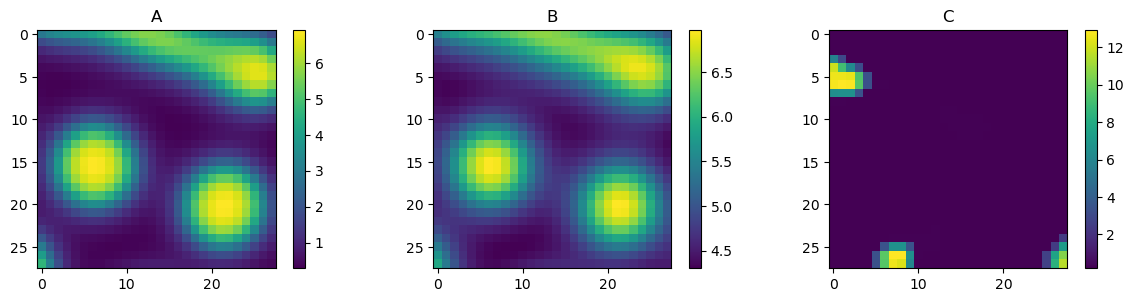

Epoch: 45000 
 data loss:0.035625, 
data A loss:0.024262, data B loss:0.008499, data C loss:0.002864, 
Laplacian A loss:0.074934, Laplacian B loss:0.048636
Physics loss:0.226336
Negative loss:0.000000

 b_A=0.0121, b_B=12.9703, b_C=0.0265, V_A=21.3647, V_B=112.4792, V_C=44.4776, mu_A=0.5289, mu_B=5.6642, K_AA=5.3932, K_AB=5.2669, K_AC=20.3049, K_BA=5.6362, K_BC=12.8147, K_CB=8.9957, K_CC=64.3039, n_AA=3.3693, n_AB=3.4364, n_AC=6.0002, n_BA=4.2072, n_BC=4.2630, n_CB=6.0186, n_CC=1.1042


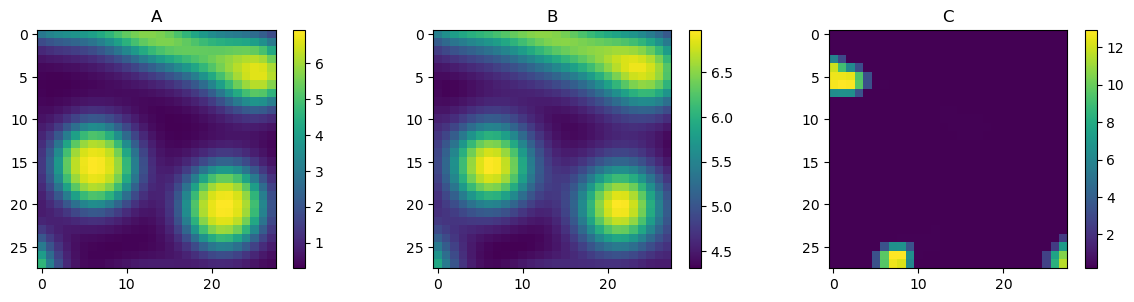

Epoch: 50000 
 data loss:0.050362, 
data A loss:0.024199, data B loss:0.007652, data C loss:0.018512, 
Laplacian A loss:0.083812, Laplacian B loss:0.043945
Physics loss:0.211015
Negative loss:0.000000

 b_A=0.0155, b_B=12.9658, b_C=0.0271, V_A=21.4463, V_B=112.4645, V_C=45.4344, mu_A=0.5304, mu_B=5.6624, K_AA=5.3801, K_AB=5.2653, K_AC=20.5637, K_BA=5.6312, K_BC=12.8930, K_CB=8.9580, K_CC=66.0276, n_AA=3.3787, n_AB=3.4360, n_AC=6.0002, n_BA=4.2209, n_BC=4.2358, n_CB=6.0163, n_CC=1.0997


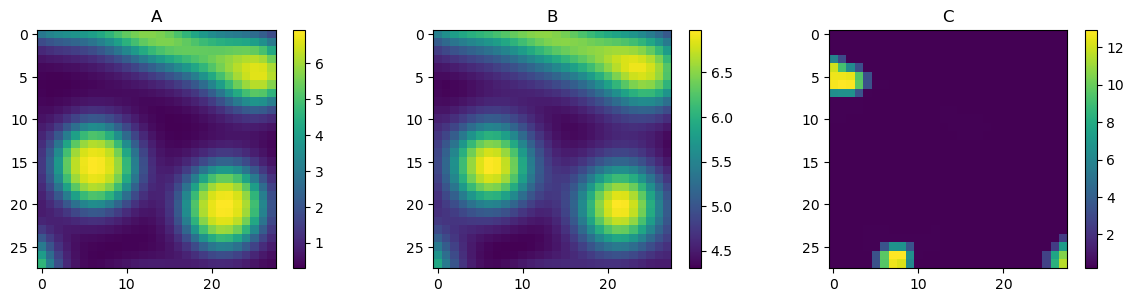

Epoch: 55000 
 data loss:0.035226, 
data A loss:0.024275, data B loss:0.008872, data C loss:0.002079, 
Laplacian A loss:0.112983, Laplacian B loss:0.047656
Physics loss:0.234623
Negative loss:0.000000

 b_A=0.0123, b_B=12.9589, b_C=0.0276, V_A=21.4849, V_B=112.4521, V_C=46.3169, mu_A=0.5305, mu_B=5.6618, K_AA=5.3908, K_AB=5.2668, K_AC=20.8010, K_BA=5.6187, K_BC=12.9910, K_CB=8.8822, K_CC=67.6075, n_AA=3.3704, n_AB=3.4383, n_AC=6.0002, n_BA=4.1806, n_BC=4.2253, n_CB=6.0171, n_CC=1.0969


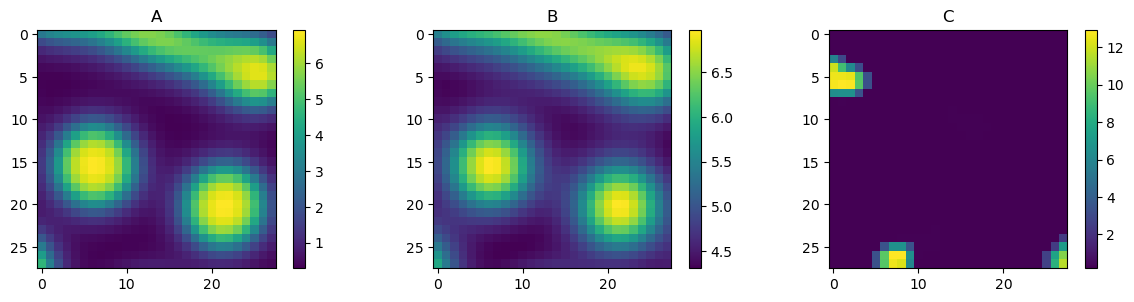

Epoch: 60000 
 data loss:0.043561, 
data A loss:0.025505, data B loss:0.016142, data C loss:0.001914, 
Laplacian A loss:0.248717, Laplacian B loss:0.110155
Physics loss:0.458568
Negative loss:0.000000

 b_A=0.0226, b_B=12.9741, b_C=0.0278, V_A=21.5595, V_B=112.4590, V_C=47.1066, mu_A=0.5186, mu_B=5.6517, K_AA=5.3826, K_AB=5.2568, K_AC=21.0168, K_BA=5.6237, K_BC=13.0949, K_CB=8.9161, K_CC=69.0445, n_AA=3.3703, n_AB=3.4267, n_AC=6.0002, n_BA=4.1975, n_BC=4.2384, n_CB=6.0269, n_CC=1.0943


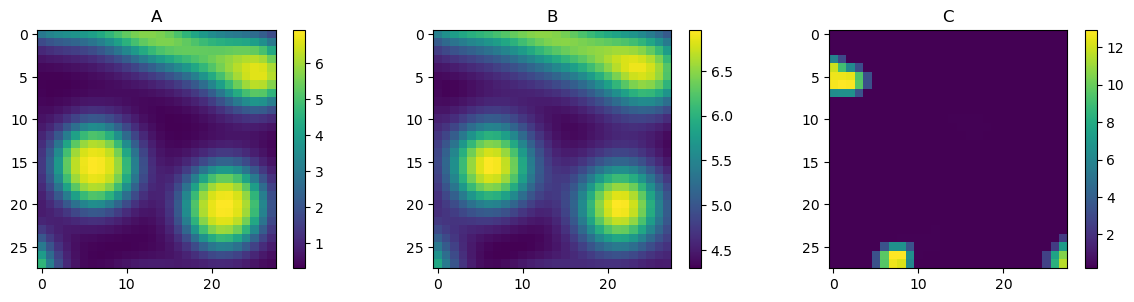

Epoch: 65000 
 data loss:0.033195, 
data A loss:0.023934, data B loss:0.007469, data C loss:0.001793, 
Laplacian A loss:0.039261, Laplacian B loss:0.038480
Physics loss:0.199729
Negative loss:0.000000

 b_A=0.0141, b_B=12.9585, b_C=0.0250, V_A=21.5895, V_B=112.4452, V_C=47.8443, mu_A=0.5295, mu_B=5.6611, K_AA=5.3819, K_AB=5.2656, K_AC=21.2126, K_BA=5.6116, K_BC=13.1811, K_CB=8.8793, K_CC=70.4064, n_AA=3.3834, n_AB=3.4369, n_AC=6.0002, n_BA=4.2131, n_BC=4.2435, n_CB=6.0161, n_CC=1.0949


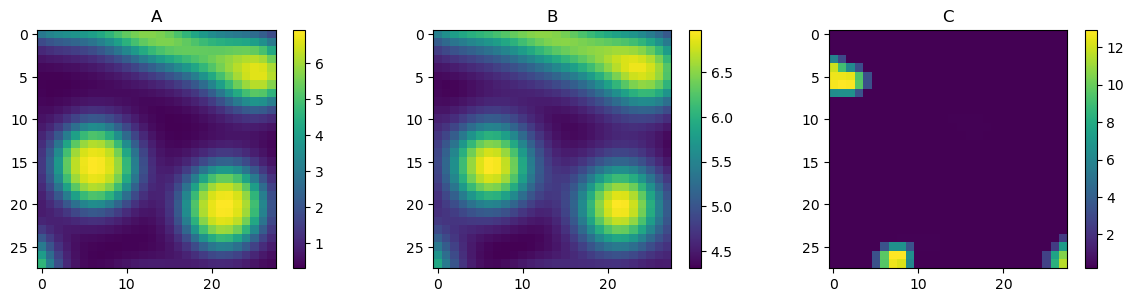

Epoch: 70000 
 data loss:0.043634, 
data A loss:0.023963, data B loss:0.008037, data C loss:0.011634, 
Laplacian A loss:0.068958, Laplacian B loss:0.045666
Physics loss:0.219691
Negative loss:0.000000

 b_A=0.0160, b_B=12.9566, b_C=0.0279, V_A=21.6175, V_B=112.4435, V_C=48.5526, mu_A=0.5274, mu_B=5.6579, K_AA=5.3831, K_AB=5.2638, K_AC=21.3947, K_BA=5.6083, K_BC=13.2848, K_CB=8.8078, K_CC=71.6467, n_AA=3.3760, n_AB=3.4351, n_AC=6.0002, n_BA=4.1879, n_BC=4.2791, n_CB=6.0184, n_CC=1.0907


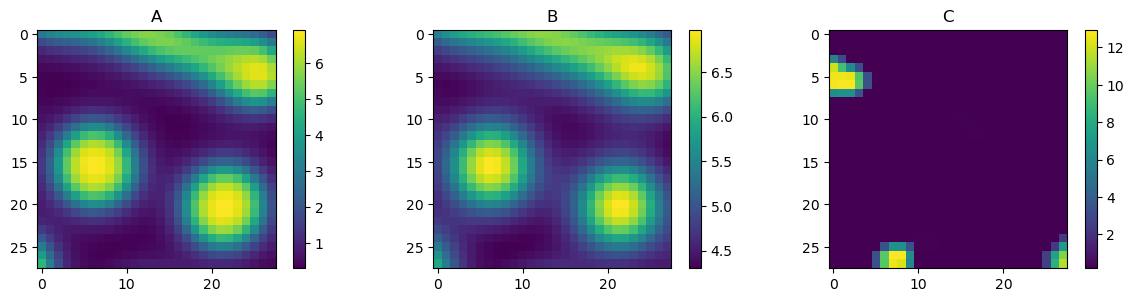

Epoch: 75000 
 data loss:0.033647, 
data A loss:0.024187, data B loss:0.007676, data C loss:0.001784, 
Laplacian A loss:0.181278, Laplacian B loss:0.042692
Physics loss:0.230609
Negative loss:0.000000

 b_A=0.0137, b_B=12.9495, b_C=0.0241, V_A=21.6476, V_B=112.4350, V_C=49.1989, mu_A=0.5298, mu_B=5.6606, K_AA=5.3811, K_AB=5.2670, K_AC=21.5566, K_BA=5.6034, K_BC=13.3032, K_CB=8.8222, K_CC=72.8364, n_AA=3.3854, n_AB=3.4382, n_AC=6.0001, n_BA=4.2071, n_BC=4.2589, n_CB=6.0161, n_CC=1.0924


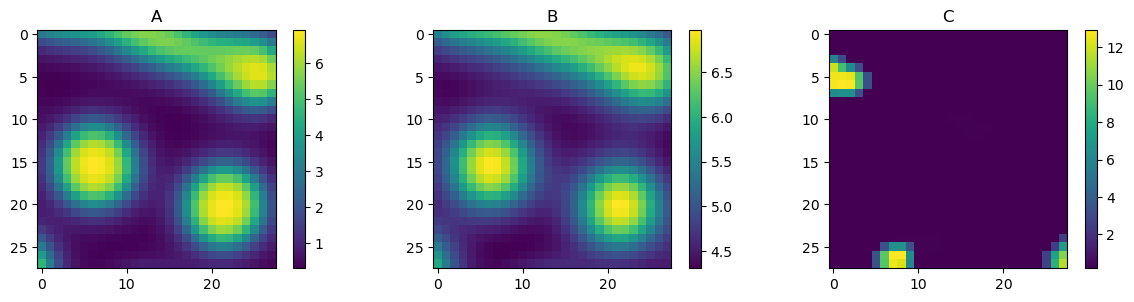

Epoch: 80000 
 data loss:0.040331, 
data A loss:0.023786, data B loss:0.007534, data C loss:0.009011, 
Laplacian A loss:0.046471, Laplacian B loss:0.039009
Physics loss:0.204642
Negative loss:0.000000

 b_A=0.0180, b_B=12.9487, b_C=0.0249, V_A=21.6721, V_B=112.4360, V_C=49.8258, mu_A=0.5300, mu_B=5.6567, K_AA=5.3729, K_AB=5.2638, K_AC=21.7124, K_BA=5.6042, K_BC=13.3814, K_CB=8.7710, K_CC=73.9166, n_AA=3.3826, n_AB=3.4353, n_AC=6.0001, n_BA=4.1934, n_BC=4.2940, n_CB=6.0164, n_CC=1.0909


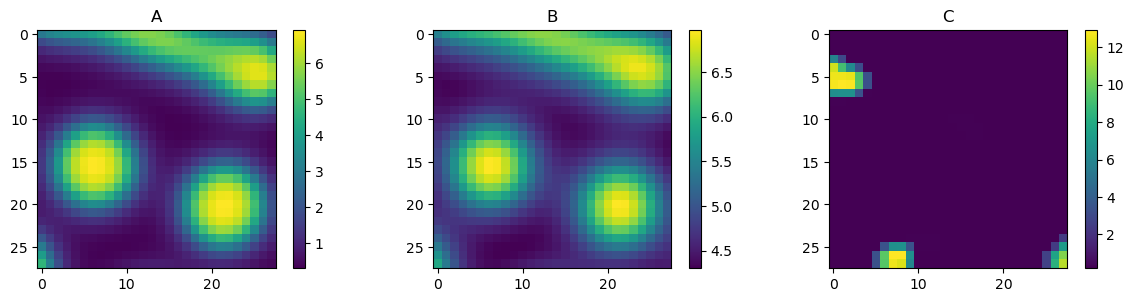

Epoch: 85000 
 data loss:0.033957, 
data A loss:0.023878, data B loss:0.008600, data C loss:0.001479, 
Laplacian A loss:0.111877, Laplacian B loss:0.056179
Physics loss:0.239526
Negative loss:0.000000

 b_A=0.0171, b_B=12.9488, b_C=0.0255, V_A=21.7025, V_B=112.4354, V_C=50.3832, mu_A=0.5258, mu_B=5.6549, K_AA=5.3800, K_AB=5.2626, K_AC=21.8617, K_BA=5.6016, K_BC=13.3926, K_CB=8.7903, K_CC=74.9790, n_AA=3.3814, n_AB=3.4339, n_AC=6.0002, n_BA=4.1998, n_BC=4.2498, n_CB=6.0154, n_CC=1.0879


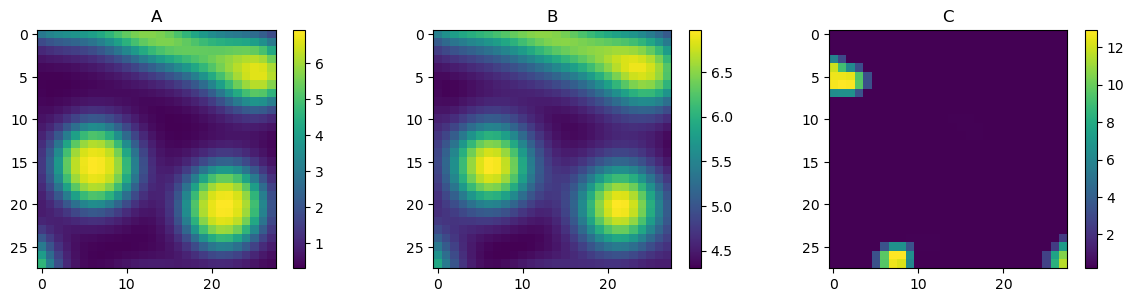

Epoch: 90000 
 data loss:0.032495, 
data A loss:0.023677, data B loss:0.007378, data C loss:0.001440, 
Laplacian A loss:0.034687, Laplacian B loss:0.034486
Physics loss:0.197446
Negative loss:0.000000

 b_A=0.0164, b_B=12.9265, b_C=0.0238, V_A=21.6887, V_B=112.4194, V_C=50.9220, mu_A=0.5315, mu_B=5.6533, K_AA=5.3720, K_AB=5.2650, K_AC=22.0002, K_BA=5.5954, K_BC=13.4612, K_CB=8.7365, K_CC=75.9656, n_AA=3.3800, n_AB=3.4364, n_AC=6.0001, n_BA=4.1667, n_BC=4.2738, n_CB=6.0157, n_CC=1.0884


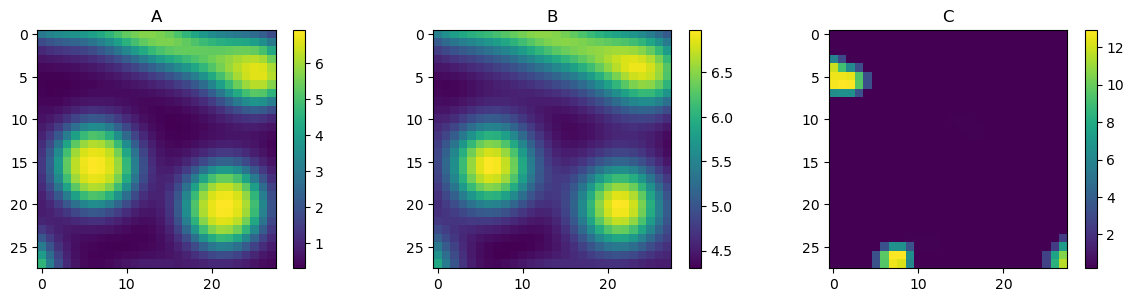

Epoch: 95000 
 data loss:0.040053, 
data A loss:0.023537, data B loss:0.007458, data C loss:0.009059, 
Laplacian A loss:0.089683, Laplacian B loss:0.039455
Physics loss:0.194003
Negative loss:0.000000

 b_A=0.0136, b_B=12.9341, b_C=0.0255, V_A=21.7356, V_B=112.4233, V_C=51.4508, mu_A=0.5286, mu_B=5.6549, K_AA=5.3812, K_AB=5.2652, K_AC=22.1332, K_BA=5.5933, K_BC=13.5191, K_CB=8.8041, K_CC=76.8903, n_AA=3.3880, n_AB=3.4364, n_AC=6.0001, n_BA=4.2058, n_BC=4.2903, n_CB=6.0154, n_CC=1.0858


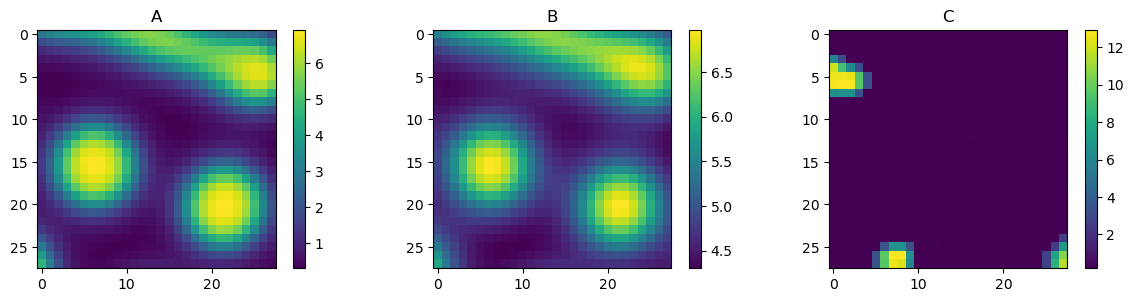

Epoch: 100000 
 data loss:0.032983, 
data A loss:0.023587, data B loss:0.008059, data C loss:0.001337, 
Laplacian A loss:0.055733, Laplacian B loss:0.037544
Physics loss:0.209524
Negative loss:0.000000

 b_A=0.0119, b_B=12.9262, b_C=0.0212, V_A=21.7530, V_B=112.4172, V_C=51.9272, mu_A=0.5293, mu_B=5.6554, K_AA=5.3847, K_AB=5.2671, K_AC=22.2601, K_BA=5.5894, K_BC=13.5360, K_CB=8.8047, K_CC=77.7904, n_AA=3.3872, n_AB=3.4382, n_AC=6.0001, n_BA=4.2008, n_BC=4.2643, n_CB=6.0148, n_CC=1.0887


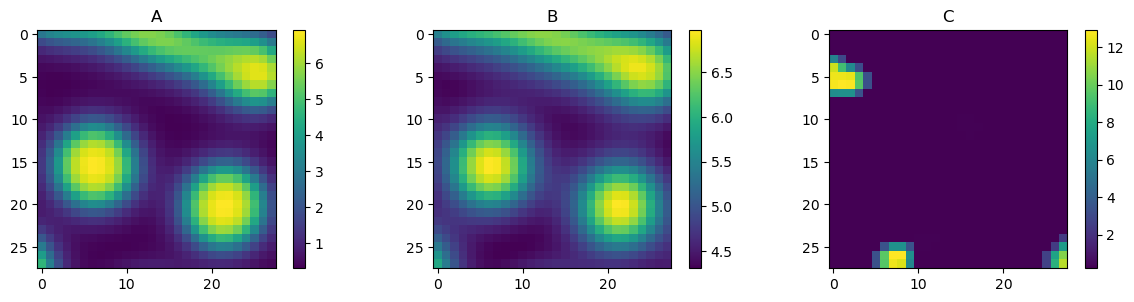

    Early dtoped at 100437
Epoch: 100437 
 data loss:0.032236, 
data A loss:0.023509, data B loss:0.007393, data C loss:0.001334, 
Laplacian A loss:0.035438, Laplacian B loss:0.033536
Physics loss:0.194678
Negative loss:0.000000

 b_A=0.0161, b_B=12.9249, b_C=0.0219, V_A=21.7498, V_B=112.4175, V_C=51.9645, mu_A=0.5302, mu_B=5.6529, K_AA=5.3762, K_AB=5.2654, K_AC=22.2710, K_BA=5.5922, K_BC=13.5414, K_CB=8.7680, K_CC=77.8656, n_AA=3.3848, n_AB=3.4364, n_AC=6.0001, n_BA=4.1863, n_BC=4.2661, n_CB=6.0140, n_CC=1.0879


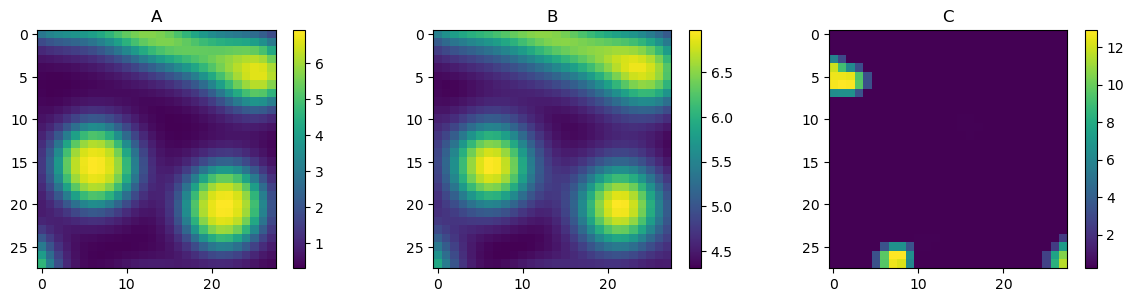

In [6]:
torch.manual_seed(42)
np.random.seed(42)
dtype = torch.float32
torch.set_default_dtype(dtype)

def create_var(init=None):
    if init is None:
        return torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str)), []
    else:
        return torch.nn.Parameter(init*torch.ones(1, requires_grad=True, device=dev_str)), []


D_A=params["D_A"]#, sampled_D_A = create_var()
D_B=params["D_B"]#, sampled_D_B = create_var()
b_A, sampled_b_A = create_var(1)
b_B, sampled_b_B = create_var(1)
b_C, sampled_b_C = create_var(1)
V_A, sampled_V_A = create_var(1)
V_B, sampled_V_B = create_var(1)
V_C, sampled_V_C = create_var(1)
mu_A, sampled_mu_A = create_var(1)
mu_B, sampled_mu_B = create_var(1)
mu_C=params["mu_C"]#, sampled_mu_C = create_var()
K_AA, sampled_K_AA = create_var(1)#K_AA_init)
K_AB, sampled_K_AB = create_var(1)#K_AB_init)
K_AC, sampled_K_AC = create_var(1)#K_AC_init)
K_BA, sampled_K_BA = create_var(1)#K_BA_init)
K_BC, sampled_K_BC = create_var(1)#K_BC_init)
K_CB, sampled_K_CB = create_var(1)#K_CB_init)
K_CC, sampled_K_CC = create_var(1)#K_CC_init)
n_AA, sampled_n_AA = create_var(2)#= params['n']
n_AB, sampled_n_AB = create_var(2)#= params['n']
n_AC, sampled_n_AC = create_var(2)#= params['n']
n_BA, sampled_n_BA = create_var(2)#= params['n']
n_BC, sampled_n_BC = create_var(2)#= params['n']
n_CB, sampled_n_CB = create_var(2)#= params['n']
n_CC, sampled_n_CC = create_var(2)#= params['n']

params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC", 
                     "n_AA", "n_AB", "n_AC",
                     "n_BA", "n_BC",
                     "n_CB", "n_CC",
]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC, 
               n_AA, n_AB, n_AC, n_BA, n_BC,
               n_CB, n_CC
]

params_sampled_list =[#sampled_D_A, sampled_D_B,
                      sampled_b_A, sampled_b_B, sampled_b_C, sampled_V_A, sampled_V_B, sampled_V_C,
                      sampled_mu_A, sampled_mu_B, #sampled_mu_C,
                      sampled_K_AA, sampled_K_AB, sampled_K_AC, sampled_K_BA, sampled_K_BC,
                      sampled_K_CB, sampled_K_CC,
                      sampled_n_AA, sampled_n_AB, sampled_n_AC,
                      sampled_n_BA, sampled_n_BC, 
                      sampled_n_CB, sampled_n_CC,
                     ]

###########################################################
# Inputs
# restrict to inner boundaries
x = torch.linspace(0, run_params.Lx, run_params.Ix)[x_slice].to(device)
y = torch.linspace(0, run_params.Ly, run_params.Jy)[y_slice].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

def transform(x, l, u):
    return (u-l)*x + l

x2 = transform(torch.rand(run_params.Ix),torch.min(x).item(),torch.max(x).item())
y2 = transform(torch.rand(run_params.Jy),torch.min(y).item(),torch.max(y).item())
X2,Y2 = torch.meshgrid(x2, y2, indexing='ij')
physics_X = torch.vstack([X2.flatten(), Y2.flatten()]).T.requires_grad_(True).to(device)
##########################################################
#   Data
# restrict to inner boundaries
data_A = torch.from_numpy(A_n[x_slice,y_slice].flatten()).to(device)
data_B = torch.from_numpy(B_n[x_slice,y_slice].flatten()).to(device)
data_C = torch.from_numpy(C_n[x_slice,y_slice].flatten()).to(device)
###########################################################
# Laplacians
# First, find the finite-diff Laplacian on the whole domain,
# then, select the inner boundaries. This way, the boundaries 
# effets removed
diffusion_scale_factor = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
laplacianA = diffusion_scale_factor * grad_diff(A_n)
laplacianB = diffusion_scale_factor * grad_diff(B_n)

laplacianA = torch.tensor(laplacianA[x_slice,y_slice].flatten()).to(device)
laplacianB = torch.tensor(laplacianB[x_slice,y_slice].flatten()).to(device)
###########################################################
zeors_tensor = torch.zeros(data_X.shape[0]).to(device)
###########################################################
# Model
lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
model = Net_sep_dense_normalised(2,3,[128,128,128,128], lb, ub).to(device)
###########################################################
# optimizer
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 1e-4},
                              {'params': params_list, 'lr': .1},
                              #{'params': [n], 'lr': 0.5}
                             ]
                              , lr=1e-4)#.LBFGS([*model.parameters(), *params_list], lr=1
                             #,line_search_fn='strong_wolfe')#


epochs = 100000
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_physics = 1e-3
loss_laplacian_physics = 0.0
lambda_physics_laplacian = 1e-2
loss_negative = 0
lambda_negative = 100

losses = np.zeros((7, epochs + 6000))
last_loss = np.inf

negative_threshold = nn.Threshold(0.0, 0.0)

def act_t(x, km, n=2):
    return negative_threshold(x)**n / (negative_threshold(x)**n + km**n)

def inh_t(x, km, n=2):
    return km**n / (negative_threshold(x)**n + km**n)

for i in range(epochs + 6000): 
    # L-BFGS
    def closure():
        
        optimizer.zero_grad()

        #################################
        # data loss
        data_f_hat = model(data_X)
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        loss_A_data = torch.mean((data_A - data_A_hat)**2)
        loss_B_data = torch.mean((data_B - data_B_hat)**2)
        loss_C_data = torch.mean((data_C - data_C_hat)**2)
        loss_data = (loss_A_data + loss_B_data + loss_C_data)/3
        #################################
        loss_negative = torch.mean(torch.maximum(-data_A_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_B_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_C_hat, zeors_tensor)**2
                       )
        #################################
        # Laplacians derivatives        
        laplacianA_hat = Laplacian(data_A_hat, data_X)
        laplacianB_hat = Laplacian(data_B_hat, data_X)
        
        A_loss_laplacian = torch.mean((laplacianA_hat-laplacianA)**2)
        B_loss_laplacian = torch.mean((laplacianB_hat-laplacianB)**2)
        loss_laplacian_physics = A_loss_laplacian + B_loss_laplacian
        ###############################
        # physics derivatives  
        physics_f_hat = model(physics_X)
        A = physics_f_hat[0].squeeze() 
        B = physics_f_hat[1].squeeze() 
        C = physics_f_hat[2].squeeze() 
        
        laplacianA_hat = Laplacian(A, physics_X)
        laplacianB_hat = Laplacian(B, physics_X)
        
        F_A =  b_A + V_A*act_t(A, K_AA, n_AA)*inh_t(B, K_BA, n_BA) - mu_A * A    
        F_B =  b_B + V_B*act_t(A, K_AB, n_AB)*inh_t(C, K_CB, n_CB) - mu_B * B        
        F_C =  b_C + V_C*inh_t(A, K_AC, n_AC)*inh_t(B, K_BC, n_BC)*act_t(C, K_CC, n_CC) - mu_C * C        

        dAdt = D_A * laplacianA_hat + F_A
        dBdt = D_B * laplacianB_hat + F_B
        dCdt = F_C
        ################################
        # physics loss
        # Construct the physics loss here
        A_loss_physics = torch.mean(dAdt**2)
        B_loss_physics = torch.mean(dBdt**2)
        C_loss_physics = torch.mean(dCdt**2)
        loss_physics = (A_loss_physics  
                        + B_loss_physics 
                        + C_loss_physics)
        ###############################
        total_loss = (
            +lambda_data*loss_data            
            +lambda_physics_laplacian*loss_laplacian_physics
            +lambda_physics*loss_physics
            #+lambda_negative*loss_negative
                        )

        total_loss.backward(retain_graph=True)
        
        
        losses[:,i] = (loss_A_data.item(), loss_B_data.item(), loss_C_data.item(), 
                       A_loss_laplacian.item(), B_loss_laplacian.item(),
                       loss_physics.item(), loss_negative.item())                    
            
        return total_loss
    
    
    
    optimizer.step(closure)
    
    def show_outputs(i):
        ls = np.sqrt(losses[:, i])
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{np.sum(ls[0:3]):.6f}, \n"
              f"data A loss:{ls[0]:.6f}, data B loss:{ls[1]:.6f}, data C loss:{ls[2]:.6f}, \n"
              f"Laplacian A loss:{ls[3]:.6f}, Laplacian B loss:{ls[4]:.6f}\n"
              f"Physics loss:{ls[5]:.6f}\n"
              f"Negative loss:{ls[6]:.6f}\n"
              f"\n"
              ,
              ", ".join([f"{name}={param.item():.4f}" for param, name in zip(params_list, params_name_list)])
             )
        data_f_hat = model(data_X)        
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
                   to(data_B_hat.cpu().detach().numpy()), 
                   to(data_C_hat.cpu().detach().numpy())], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show()
       
    
    if i < epochs and last_loss > np.sum(losses[:,i]):
        last_loss =  np.sum(losses[:,i])
            
    elif np.sum(losses[:,i]) < last_loss:
        print("============================================")
        print(f"    Early dtoped at {i+1}")
        print("============================================")
        show_outputs(i)
        early_stop = True
        with torch.no_grad():
            for i,(param, name) in enumerate(zip(params_list, params_name_list)):
                l,u = get_bound(name)
                param[:] = param.clamp(l,u)
                params_sampled_list[i].append(param.item())
        break        
    
    if (i+1)%5000 == 0 or i==0:        
        show_outputs(i)
        
    with torch.no_grad():
        for i,(param, name) in enumerate(zip(params_list, params_name_list)):
#             if name == "n":
#                 closest_int = np.rint(param.item())
#                 if closest_int < n_bound[0]:
#                     closest_int = n_bound[0]
#                 elif closest_int > n_bound[1]:
#                     closest_int = n_bound[1]
#                 param[:] = closest_int
#                 params_sampled_list[i].append(param.item())
#             else:
            l,u = get_bound(name)
            param[:] = param.clamp(l,u)
            params_sampled_list[i].append(param.item())
            


# Plot the trained outputs

A RMSE:0.023511306803339328 B RMSE:0.007422816563535617 C RMSE:0.0013336432247169456
F_A actual:0.5416853390991865, F_A:0.5382336378097534, RMSE: 0.014050477305596408
F_B actual:476.0016768708527, F_B:467.26824951171875, RMSE: 0.30355906475191796
F_C actual:0.3549702247494855, F_C:0.3536887764930725, RMSE: 0.011595874091150996

Laplacian A RMSE: 0.034982049211313516
Laplacian B RMSE: 0.03312569648606837

dAdt RMSE: 0.014032212678163469
dBdt RMSE: 0.3079022564648278
dCdt RMSE: 0.011595874091150996


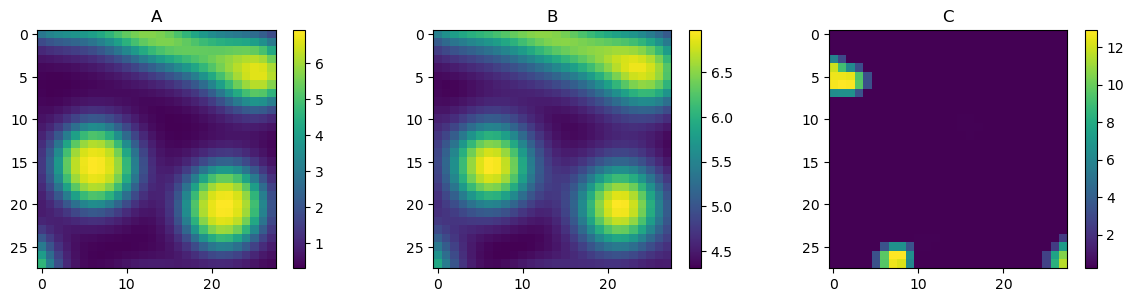

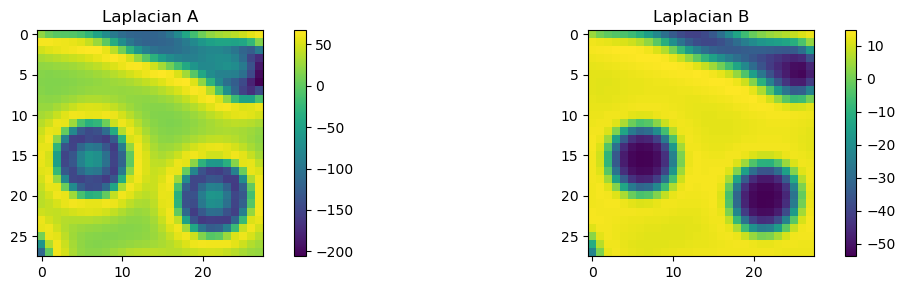

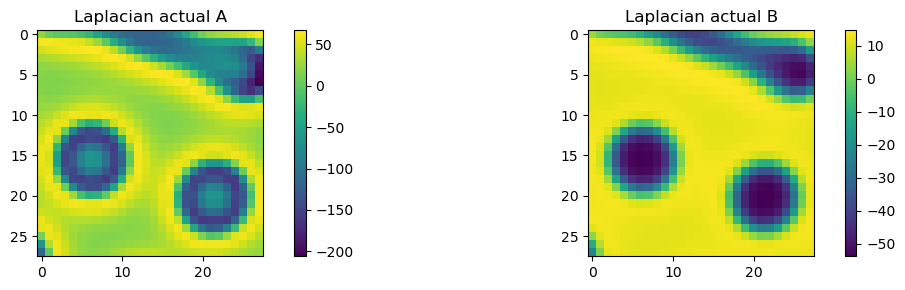

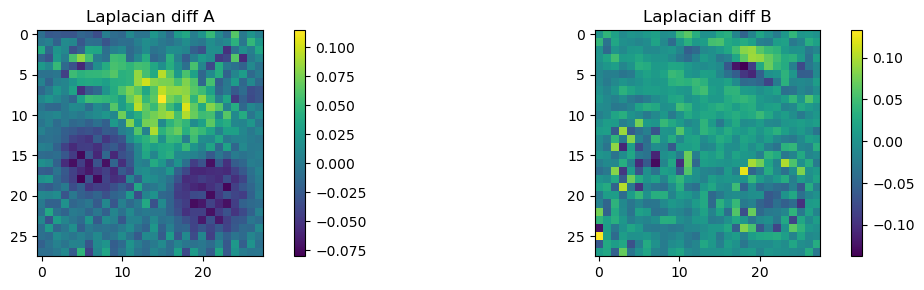

In [7]:
def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return km**n / (x**n + km**n)

physics_f = model(data_X)
A_hat = physics_f[0].squeeze()
B_hat = physics_f[1].squeeze()
C_hat = physics_f[2].squeeze()

laplacianA_hat = Laplacian(A_hat, data_X)
laplacianB_hat = Laplacian(B_hat, data_X)

A_hat = to(A_hat.cpu().detach().numpy())
B_hat = to(B_hat.cpu().detach().numpy())
C_hat = to(C_hat.cpu().detach().numpy())
laplacianA_hat = to(laplacianA_hat.cpu().detach().numpy())
laplacianB_hat = to(laplacianB_hat.cpu().detach().numpy())


laplacianA = diffusion_scale_factor * grad_diff(A_n)[x_slice,y_slice]
laplacianB = diffusion_scale_factor * grad_diff(B_n)[x_slice,y_slice]

n = params["n"]

A = A_n[x_slice,y_slice]
B = B_n[x_slice,y_slice]
C = C_n[x_slice,y_slice]

F_A =  params["b_A"] + params["V_A"]*act(A, params["K_AA"], n)*inh(B, params["K_BA"], n) - params["mu_A"] * A
F_A_hat =  params["b_A"] + params["V_A"]*act(A_hat, params["K_AA"], n)*inh(B_hat, params["K_BA"], n) - params["mu_A"] * A_hat
F_B =  params["b_B"] + params["V_B"]*act(A, params["K_AB"], n)*inh(C, params["K_CB"], n) - params["mu_B"] * B
F_B_hat =  params["b_B"] + params["V_B"]*act(A_hat, params["K_AB"], n)*inh(C_hat, params["K_CB"], n) - params["mu_B"] * B_hat
F_C =  params["b_C"] + params["V_C"]*inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n) - params["mu_C"] * C
F_C_hat =  params["b_C"] + params["V_C"]*inh(A_hat, params["K_AC"], n)*inh(B_hat, params["K_BC"], n)*act(C_hat, params["K_CC"], n) - params["mu_C"] * C_hat


dAdt = params["D_A"]*laplacianA + F_A
dAdt_hat = params["D_A"]*laplacianA_hat + F_A_hat
dBdt = params["D_B"]*laplacianB + F_B
dBdt_hat = params["D_B"]*laplacianB_hat + F_B_hat

print(f"A RMSE:{np.sqrt(np.mean((A_hat-A)**2))}",
      f"B RMSE:{np.sqrt(np.mean((B_hat-B)**2))}",
      f"C RMSE:{np.sqrt(np.mean((C_hat-C)**2))}")

print(f"F_A actual:{np.mean(F_A**2)}, F_A:{np.mean(F_A_hat**2)}, RMSE: {np.sqrt(np.mean((F_A - F_A_hat)**2))}")
print(f"F_B actual:{np.mean(F_B**2)}, F_B:{np.mean(F_B_hat**2)}, RMSE: {np.sqrt(np.mean((F_B - F_B_hat)**2))}")
print(f"F_C actual:{np.mean(F_C**2)}, F_C:{np.mean(F_C_hat**2)}, RMSE: {np.sqrt(np.mean((F_C - F_C_hat)**2))}")
      

print()
print(f"Laplacian A RMSE: {np.sqrt(np.mean((laplacianA_hat-laplacianA)**2))}")
print(f"Laplacian B RMSE: {np.sqrt(np.mean((laplacianB_hat-laplacianB)**2))}")

print()
print(f"dAdt RMSE: {np.sqrt(np.mean((dAdt-dAdt_hat)**2))}")
print(f"dBdt RMSE: {np.sqrt(np.mean((dBdt-dBdt_hat)**2))}")
print(f"dCdt RMSE: {np.sqrt(np.mean((F_C-F_C_hat)**2))}")

plot_n_im([A_hat, B_hat, C_hat], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([laplacianA_hat, laplacianB_hat], 
          ["Laplacian A", "Laplacian B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA, laplacianB], 
          ["Laplacian actual A", "Laplacian actual B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA_hat-laplacianA, laplacianB_hat-laplacianB], 
          ["Laplacian diff A", "Laplacian diff B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()



# Plot losses

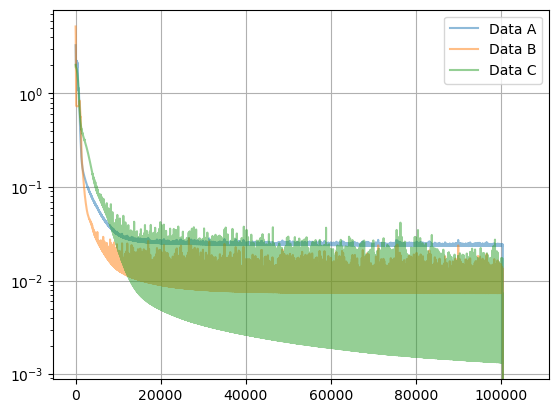

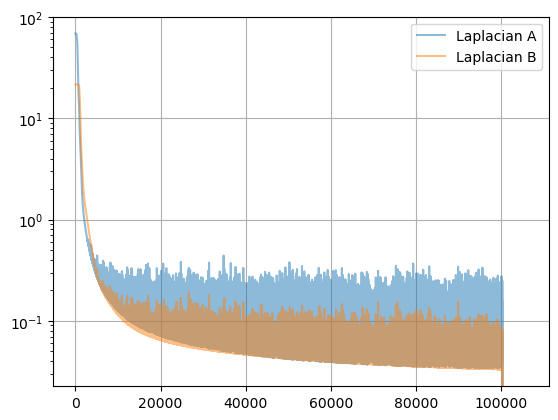

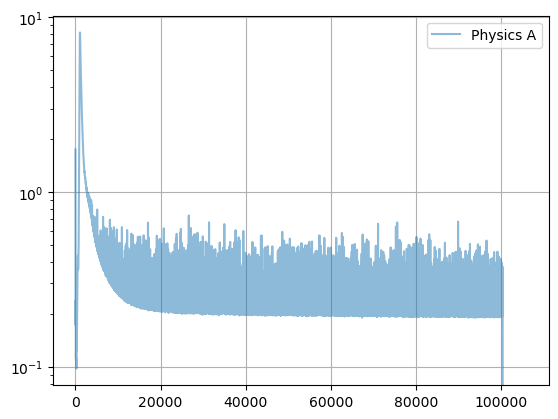

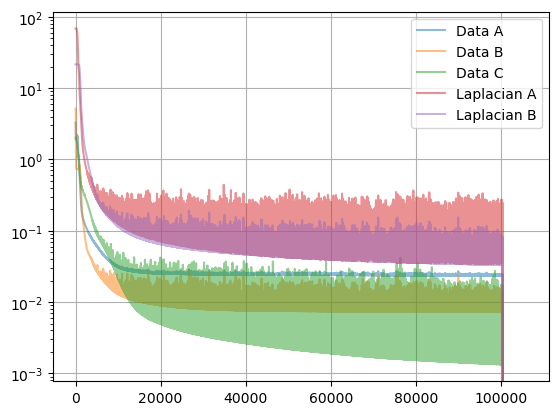

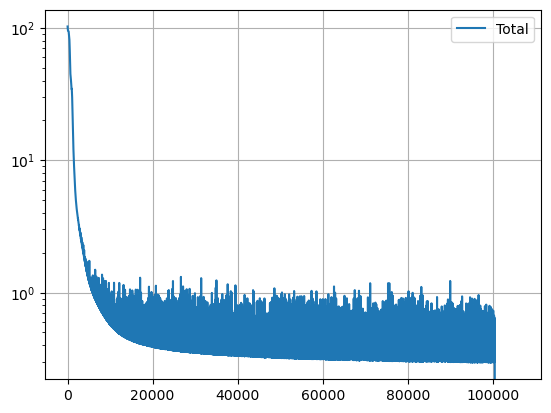

In [8]:
ls= np.sqrt(losses)
plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[5,:], alpha=.5, label="Physics A")
plt.yscale('log');plt.grid();plt.legend();plt.show()


plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log'); plt.grid();plt.legend();plt.show()

plt.plot(np.sum(ls, axis=0), label="Total")
plt.yscale('log'); plt.grid();plt.legend();plt.show()


# Plot the trained Field and its difference

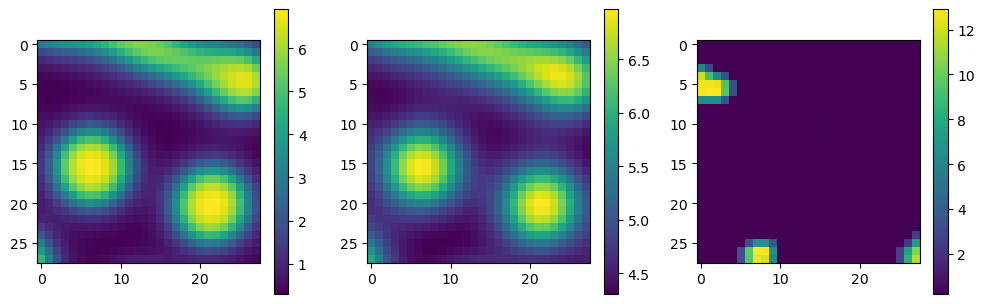

In [9]:
solution_hat = model(data_X)
A_hat = to(solution_hat[0].cpu().detach().numpy())
B_hat = to(solution_hat[1].cpu().detach().numpy())
C_hat = to(solution_hat[2].cpu().detach().numpy())
_ = plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(A_hat)
plt.colorbar(shrink=.5)
plt.subplot(132)
plt.imshow(B_hat)
plt.colorbar(shrink=.5)
plt.subplot(133)
plt.imshow(C_hat)
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

0.023511306803339328
0.007422816563535617
0.0013336432247169456


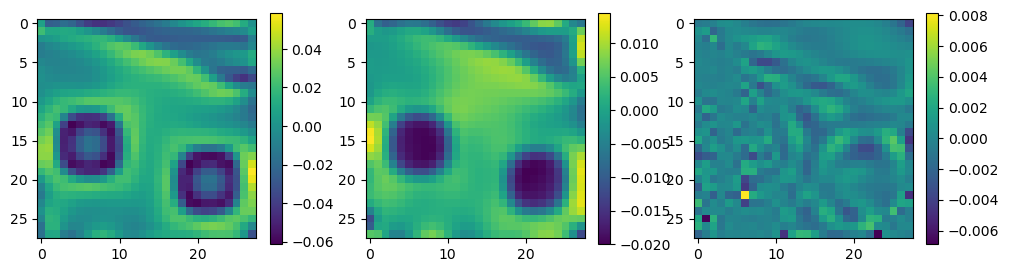

In [10]:
_ = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(A_hat-A)
print(np.sqrt(np.mean((A_hat-A)**2)))
plt.colorbar(shrink=.75)
plt.subplot(132)
plt.imshow(B_hat-B)
print(np.sqrt(np.mean((B_hat-B)**2)))
plt.colorbar(shrink=.75)
plt.subplot(133)
plt.imshow(C_hat-C)
print(np.sqrt(np.mean((C_hat-C)**2)))
plt.colorbar(shrink=.75)
plt.show()


# Second optimisation
## Find the parameters

In [11]:
estimated_params = dict()
for l, name in zip(params_list, params_name_list):    
    estimated_params[name] = l.item()

In [12]:
def get_bound(name):
    if name.startswith("K"):
        return Ks_bounds[name]
    if name.startswith("n"):
        return ns_bounds[name]
    return (np.nan,np.nan)
    

def actual_by(name):
    if name.startswith("n"):
        return params["n"]
    else:
        return params[name]
print("name \tOriginl \tEst. \tClosest Bound \tBounds")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{actual_by(name):.3f}\t\t"                                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
      for name in params_name_list
]))

name 	Originl 	Est. 	Closest Bound 	Bounds
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.016		nan		(nan,nan)
b_B:	10.000		12.925		nan		(nan,nan)
b_C:	0.100		0.022		nan		(nan,nan)
V_A:	25.000		21.750		nan		(nan,nan)
V_B:	100.000		112.417		nan		(nan,nan)
V_C:	10.000		51.965		nan		(nan,nan)
mu_A:	0.500		0.530		nan		(nan,nan)
mu_B:	5.000		5.653		nan		(nan,nan)
K_AA:	5.000		5.376		0.008		(0.008,133.498)
K_AB:	5.000		5.265		0.008		(0.008,133.498)
K_AC:	1.000		22.271		0.008		(0.008,133.498)
K_BA:	5.000		5.592		0.212		(0.212,135.116)
K_BC:	5.000		13.541		0.212		(0.212,135.116)
K_CB:	50.000		8.768		0.011		(0.011,270.911)
K_CC:	1.000		77.866		0.011		(0.011,270.911)
n_AA:	4.000		3.385		1.000		(1.000,6.000)
n_AB:	4.000		3.436		1.000		(1.000,6.000)
n_AC:	4.000		6.000		6.000		(1.000,6.000)
n_BA:	4.000		4.186		6.000		(1.000,6.000)
n_BC:	4.000		4.266		6.000		(1.000,6.000)
n_CB:	4.000		6.000		6.000		(1.000,6.000)
n_CC:	4.000	

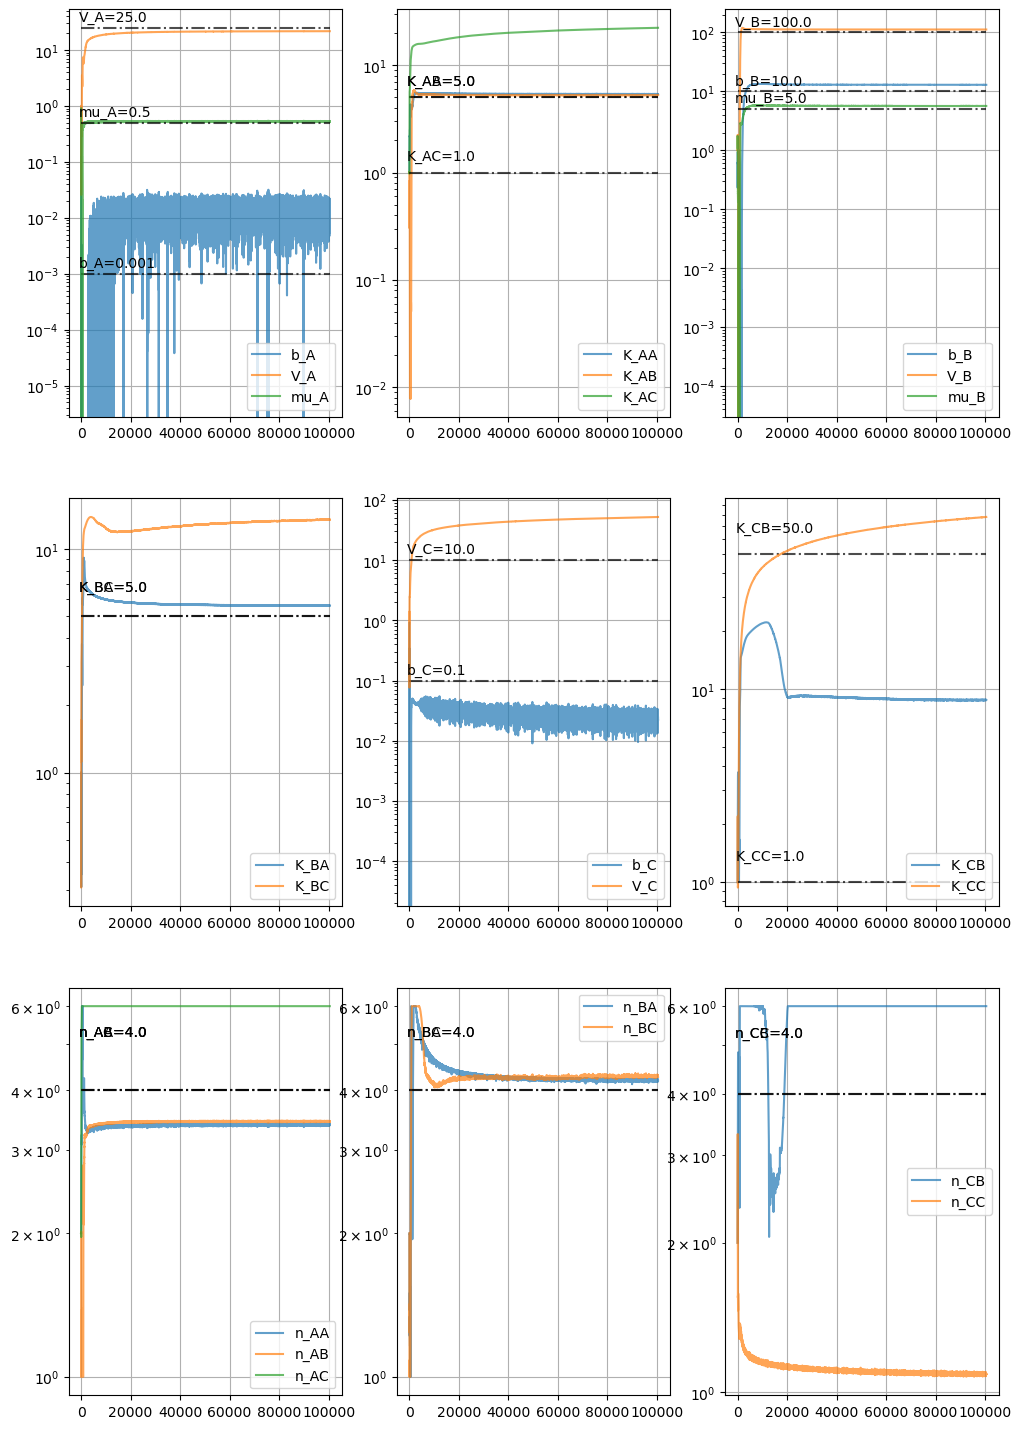

In [13]:
def plot_params(ax, names):    
    for i,(param, name) in enumerate(zip(params_list, params_name_list)):    
        if name not in names:
            continue
        ax.plot(params_sampled_list[i], label=f"{name}", alpha=.7)
        ax.hlines(actual_by(name), 0, len(params_sampled_list[i]), 
                   linestyles='-.', alpha=.7, color='black')
        ax.text(-1000, 1.3*actual_by(name), f"{name}={actual_by(name)}")
    plt.yscale('log');plt.legend();plt.grid()   
    
_ = plt.figure(figsize=(12,18))
plot_params(plt.subplot(331), ["b_A", "mu_A", "V_A"])
plot_params(plt.subplot(332), ["K_AA","K_AB","K_AC"])
plot_params(plt.subplot(333), ["b_B", "mu_B", "V_B"])
plot_params(plt.subplot(334), ["K_BA","K_BC"])
plot_params(plt.subplot(335), ["b_C", "mu_C", "V_C"])
plot_params(plt.subplot(336), ["K_CB","K_CC"])
plot_params(plt.subplot(337), ["n_AA", "n_AB", "n_AC"])
plot_params(plt.subplot(338), ["n_BA", "n_BC"])
plot_params(plt.subplot(339), ["n_CB", "n_CC"])

In [14]:
import pickle

torch.save(model, "./07_outputs/model_PINN_60")
torch.save(model.state_dict(), "./07_outputs/model_PINN_state_60")
with open('./07_outputs/model_PINN_params_name_list_60.npy', 'wb') as f:
    np.save(f, params_name_list)    
with open('./07_outputs/model_PINN_losses_60.npy', 'wb') as f:
    np.save(f, losses)    
with open(f"./07_outputs/model_PINN_estimated_params_60.pkl", "wb") as f:
    pickle.dump((dict(params),  dict(estimated_params)), f)    
with open(f"./07_outputs/model_PINN_estimated_params_list_60.pkl", "wb") as f:
    pickle.dump(params_sampled_list, f)    

In [15]:
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D

D_A, D_B , mu_C= 0.01, 1.0, params["mu_C"]
model_integrator = RD_2D_1st_Order(Ds=[D_A, D_B, 0], 
                        delta_t=100/5000, 
                        Lx=10, Ly=10, 
                        Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D)

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [16]:
def create_circuit_3954_2(
    b_A, mu_A, V_A, K_AA, K_AB, K_AC, b_B, mu_B, V_B, K_BA, K_BC, b_C, mu_C, V_C, K_CB, K_CC,
    n_AA, n_AB, n_AC, n_BA, n_BC, n_CB, n_CC,
):
    def circuit_3954(A, B, C):
        fA_v = b_A + V_A * act(A, K_AA, n_AA) * inh(B, K_BA, n_BA) - mu_A * A
        fB_v = b_B + V_B * act(A, K_AB, n_AB) * inh(C, K_CB, n_CB) - mu_B * B
        fC_v = b_C + V_C * inh(A, K_AC, n_AC) * inh(B, K_BC, n_BC) * act(C, K_CC, n_CC) - mu_C * C
        return (fA_v, fB_v, fC_v)
    
    return circuit_3954

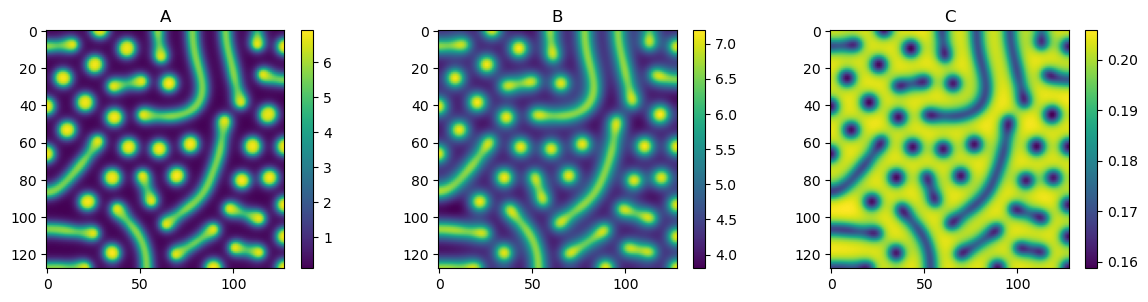

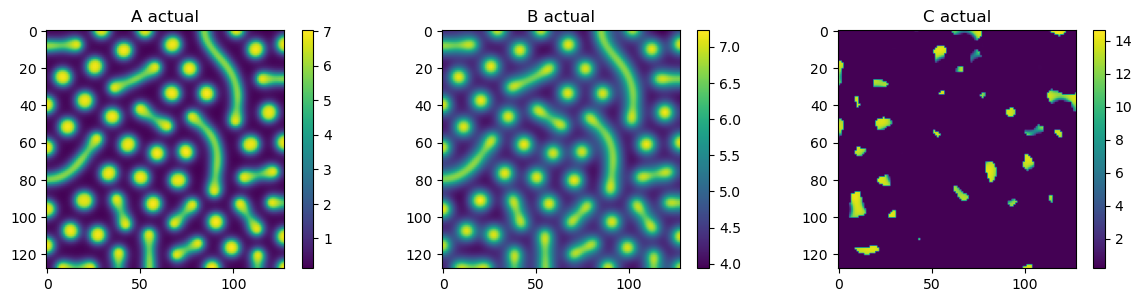

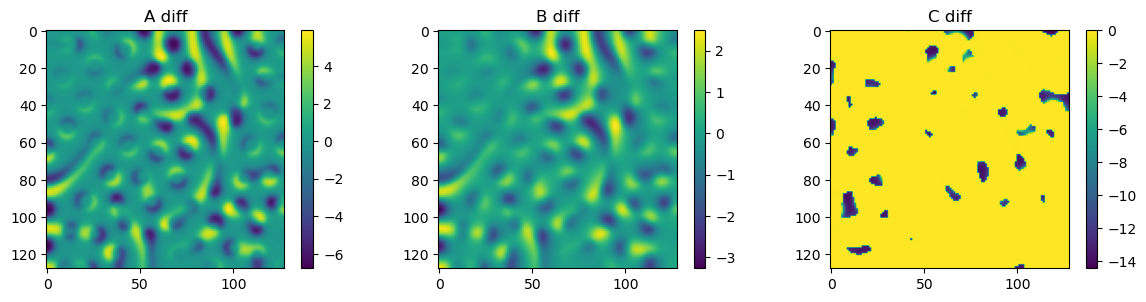

In [17]:

params2 = {}
for k,v in estimated_params.items():
    if not k.startswith("K"):
        params2[k] = v
    elif k.startswith("n"):
        # Round the n to its closest integer        
        params2[k] = np.rint(v)
    else:
        lower, upper = Ks_bounds[k]
        if v < lower:
            params2[k] = lower
        elif v > upper:
            params2[k] = upper
        else:
            params2[k] = v

kinetics = create_circuit_3954_2(params2["b_A"], params2["mu_A"], params2["V_A"], 
                                 params2["K_AA"], params2["K_AB"], params2["K_AC"],
                                 params2["b_B"], params2["mu_B"], params2["V_B"], 
                                 params2["K_BA"], params2["K_BC"],
                                 params2["b_C"], mu_C, params2["V_C"], 
                                 params2["K_CB"], params2["K_CC"],
                                 params2["n_AA"], params2["n_AB"], params2["n_AC"],
                                 params2["n_BA"], params2["n_BC"],
                                 params2["n_CB"], params2["n_CC"],
                              )

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model_integrator.integrate([A_init, B_init, C_init],kinetics, 4*5000, record_steps=5000)

A_test = solution_test[-1,0, :].reshape((128,128))
B_test = solution_test[-1,1, :].reshape((128,128))
C_test = solution_test[-1,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([solution[105, 0, :, :],solution[105, 1, :, :],solution[105, 2, :, :]], 
           ["A actual","B actual","C actual"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([A_test-solution[105, 0, :, :],
           B_test-solution[105, 1, :, :],
           C_test-solution[105, 2, :, :]], 
           ["A diff","B diff","C diff"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

In [18]:
{1:31,
2:3,
3:9, 
4:25,
5:14,
6:60,
7:24,
8:26,
9:65}

{1: 31, 2: 3, 3: 9, 4: 25, 5: 14, 6: 60, 7: 24, 8: 26, 9: 65}